# Toxic Comment Classification using Transformer Architecture

## Overview
This notebook implements a multi-label classification system using a simple Keras transformer to identify toxic comments. The model is trained on data from the Jigsaw Toxic Comment Classification Challenge.

**Key Features:**
- **Target Variable**: Sum of initial toxic labels (ranges from 0 to 6)
- **Scoring Method**: Dot product of labels and their probabilities
- **Architecture**: Custom transformer implementation from Keras examples

**Dataset Source**: [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/julian3833/jigsaw-toxic-comment-classification-challenge)

## Import Dependencies and Load Data

We'll start by importing all necessary libraries for data processing, machine learning, and natural language processing.

In [ ]:
# Import essential libraries for data manipulation and machine learning
import numpy as np
import pandas as pd

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Text processing and cleaning utilities
import re
import unidecode
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
seed = 42

# Load training and test datasets
train_set = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')

# Display first few rows of training data
train_set.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


## Text Preprocessing and Cleaning

Before training our model, we need to clean and preprocess the text data. This involves removing HTML tags, URLs, special characters, and stopwords to improve model performance.

In [ ]:
def clean_data(data):
    """
    Comprehensive text cleaning function that performs the following operations:
    1. Remove newlines, tabs, and backslashes
    2. Parse and remove HTML tags using BeautifulSoup
    3. Remove URLs and website references
    4. Convert to lowercase and remove accents
    5. Remove special characters (keep only alphanumeric and basic punctuation)
    6. Remove stopwords using NLTK
    
    Args:
        data: List of text strings to clean
        
    Returns:
        List of cleaned text strings
    """
    final = []
    for sent in data:
        # Replace common escape characters and normalize spacing
        sent = sent.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
        
        # Parse HTML content and extract plain text
        soup = BeautifulSoup(sent, "html.parser")
        sent = soup.get_text(separator=" ")
        
        # Remove HTTP URLs and website references
        remove_https = re.sub(r'http\S+', '', sent)
        sent = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        
        # Convert unicode characters to ASCII and lowercase
        sent = unidecode.unidecode(sent)
        sent = sent.lower()
        
        # Keep only alphanumeric characters and basic punctuation
        sent = re.sub(r"[^a-zA-Z0-9:$-,()%.?!]+", ' ', sent) 
        sent = re.sub(r"[:$-,()%.?!]+", ' ',sent)
        
        # Remove English stopwords
        stoplist = stopwords.words("english")
        sent = [word for word in word_tokenize(sent) if word not in stoplist]
        sent = " ".join(sent)
        final.append(sent)
    
    return final

## Dataset Analysis and Sampling

The original dataset is heavily imbalanced with most comments being non-toxic. We'll analyze the distribution and create a balanced subset for training.

In [ ]:
# Create toxicity score by summing all toxic label columns
train_set['toxicity'] = train_set.drop(['id', 'comment_text'], axis=1).sum(axis=1)

# Display distribution of toxicity scores
train_set.toxicity.value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: toxicity, dtype: int64

## Creating Balanced Training Dataset

To address class imbalance, we'll sample a limited number of non-toxic comments while keeping all toxic comments for training.

In [ ]:
# Limit non-toxic comments to prevent class imbalance
n = 15000

# Sample 'n' non-toxic comments randomly
nontoxic_sample = train_set[train_set.toxicity==0].sample(n, random_state = seed)

# Combine all toxic comments with sampled non-toxic comments
train = pd.concat([train_set[train_set.toxicity!=0], nontoxic_sample]).sort_index()
train = train[['comment_text', 'toxicity']]

# Display new distribution after sampling
train.toxicity.value_counts()

0    15000
1     6360
3     4209
2     3480
4     1760
5      385
6       31
Name: toxicity, dtype: int64

## Text Tokenization and Sequence Preparation

Convert cleaned text into numerical sequences that can be fed into our neural network model.

In [ ]:
# Apply text cleaning to both training and test datasets
train['comment_text'] = clean_data(train.comment_text)
test['text'] = clean_data(test.text)

# Set maximum sequence length for padding/truncation
max_sequence_len = 250

# Initialize and fit tokenizer on training text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.comment_text)
total_words = len(tokenizer.word_index)+1

# Convert text to sequences and apply padding
X = tokenizer.texts_to_sequences(train.comment_text)
X = pad_sequences(X, maxlen = max_sequence_len, padding='pre')

# Prepare test sequences using the same tokenizer
x_test = tokenizer.texts_to_sequences(test.text)
x_test = pad_sequences(x_test, maxlen = max_sequence_len)

# Prepare target variable
y = train.toxicity.astype(np.int8)

## Vocabulary Analysis: Toxic vs Non-Toxic Words

Let's analyze which words appear more frequently in toxic vs non-toxic comments to understand the linguistic patterns.

In [ ]:
# Create separate tokenizers for non-toxic and toxic comments
non_toxic_tokenizer = Tokenizer()
non_toxic_tokenizer.fit_on_texts(train[train.toxicity==0].comment_text)
non_toxic_count = non_toxic_tokenizer.word_counts
non_toxic_count = sorted(dict(non_toxic_count).items(), key=lambda tup: tup[1], reverse=True)

toxic_tokenizer = Tokenizer()
toxic_tokenizer.fit_on_texts(train[train.toxicity>0].comment_text)
toxic_count = toxic_tokenizer.word_counts
# Focus on top 200 most frequent words in toxic comments
toxic_count = sorted(dict(toxic_count).items(), key=lambda tup: tup[1], reverse=True)[:200]

# Merge word counts and calculate frequency ratios
all_words = pd.DataFrame(toxic_count).merge(pd.DataFrame(non_toxic_count), how='left', on=0)
all_words = all_words.dropna().reset_index()

# Calculate log ratio to identify words more common in toxic vs non-toxic comments
all_words['ratio'] = np.log(all_words['1_x'] / all_words['1_y'])

## Vocabulary Visualization

Create an interactive scatter plot to visualize the relationship between word frequency in toxic vs non-toxic comments.

In [ ]:
import plotly.express as px

# Create interactive scatter plot showing word frequency patterns
fig = px.scatter(all_words.iloc[:100], x="1_y", y="1_x", text=0, log_x=True, log_y=True, color="ratio", color_continuous_scale='Portland',
                labels={
                     "1_x": "Frequency in toxic comments",
                     "1_y": "Frequency in non-toxic comments"})

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text='Top 100 Most Frequent Words in Toxic Comments: Distribution Analysis',
    coloraxis_showscale=False)

fig.show()

## Transformer Model Architecture

Now we'll implement a custom transformer model with multi-head attention mechanism for sequence classification.

### Model Components:
1. **Token and Position Embedding**: Converts tokens to embeddings and adds positional information
2. **Transformer Blocks**: Multi-head attention with feed-forward networks
3. **Classification Head**: Dense layers for final prediction

In [ ]:
# Define model hyperparameters
embedding_dim = 256  # Dimension of token embeddings
num_heads = 4        # Number of attention heads in multi-head attention
ff_dim = 384         # Hidden layer size in feed-forward network
batch_size = 128     # Training batch size
classes = len(y.unique())  # Number of output classes


class TransformerBlock(layers.Layer):
    """
    Custom Transformer block implementing multi-head attention with residual connections.
    
    Components:
    - Multi-head attention mechanism
    - Feed-forward network with ReLU activation
    - Layer normalization and dropout for regularization
    - Residual connections around both attention and feed-forward layers
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(embedding_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Multi-head attention with residual connection
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network with residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class TokenAndPositionEmbedding(layers.Layer):
    """
    Combines token embeddings with positional embeddings.
    
    This allows the model to understand both the meaning of words (token embeddings)
    and their position in the sequence (positional embeddings).
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embedding_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Model Construction and Compilation

Build the complete model by stacking embedding layers, transformer blocks, and classification layers.

In [ ]:
# Build the complete transformer model architecture
inputs = layers.Input(shape=(max_sequence_len,))

# Apply token and position embeddings
embedding_layer = TokenAndPositionEmbedding(max_sequence_len, total_words, embedding_dim)
x = embedding_layer(inputs)

# Stack two transformer blocks for deeper representation learning
x = TransformerBlock(embedding_dim, num_heads, ff_dim)(x)
x = TransformerBlock(embedding_dim, num_heads, ff_dim)(x)

# Flatten transformer output and add classification layers
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Final classification layer with softmax for multi-class probability distribution
outputs = layers.Dense(classes, activation="softmax")(x)

# Create and compile the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=7e-5), 
    metrics=['accuracy']
)

2021-11-20 15:59:32.630809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 15:59:32.631839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 15:59:32.632510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 15:59:32.633307: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Model Architecture Summary

Let's examine the model structure and visualize its architecture.

In [ ]:
# Display detailed model architecture summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
token_and_position_embedding (None, 250, 256)          15832320  
_________________________________________________________________
transformer_block (Transform (None, 250, 256)          1250176   
_________________________________________________________________
transformer_block_1 (Transfo (None, 250, 256)          1250176   
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               163842

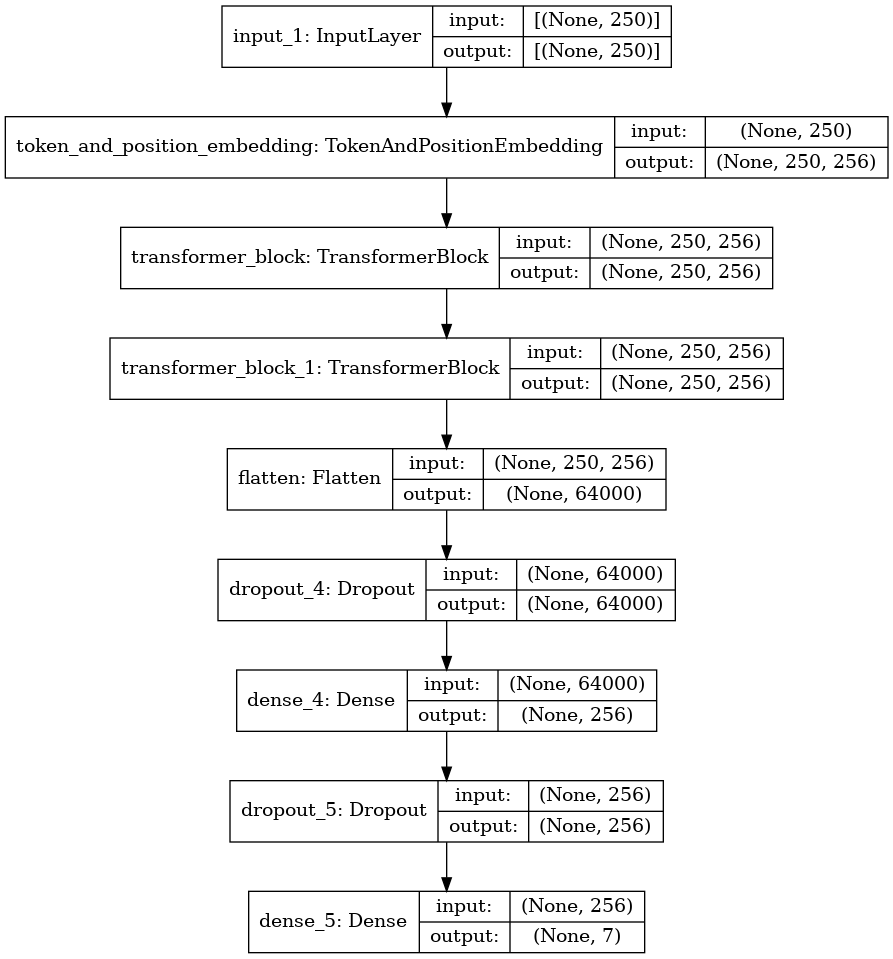

In [ ]:
# Create visual representation of model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

## Model Training

Train the model with early stopping to prevent overfitting and ensure optimal performance.

In [ ]:
# Set random seed for reproducible results
tf.random.set_seed(seed)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)

# Configure early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=7,           # Stop if no improvement for 7 epochs
    restore_best_weights=True  # Restore weights from best epoch
)

# Train the model with validation monitoring
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=40, 
    batch_size=batch_size, 
    shuffle=True,
    callbacks=[early_stopping]
)

2021-11-20 15:59:36.678092: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
220/220 [==============================] - 46s 192ms/step - loss: 2.0304 - accuracy: 0.4297 - val_loss: 1.4108 - val_accuracy: 0.4809
Epoch 2/40
220/220 [==============================] - 42s 189ms/step - loss: 1.4201 - accuracy: 0.4704 - val_loss: 1.2897 - val_accuracy: 0.4906
Epoch 3/40
220/220 [==============================] - 42s 190ms/step - loss: 1.3180 - accuracy: 0.5023 - val_loss: 1.2012 - val_accuracy: 0.5363
Epoch 4/40
220/220 [==============================] - 42s 189ms/step - loss: 1.2053 - accuracy: 0.5340 - val_loss: 1.1202 - val_accuracy: 0.5543
Epoch 5/40
220/220 [==============================] - 42s 189ms/step - loss: 1.1033 - accuracy: 0.5635 - val_loss: 1.0801 - val_accuracy: 0.5706
Epoch 6/40
220/220 [==============================] - 42s 189ms/step - loss: 1.0270 - accuracy: 0.5898 - val_loss: 1.1995 - val_accuracy: 0.5466
Epoch 7/40
220/220 [==============================] - 42s 190ms/step - loss: 0.9647 - accuracy: 0.6147 - val_loss: 1.0326 - val_ac

## Model Validation

Evaluate model performance using the validation dataset to ensure it can correctly rank comment toxicity.

In [ ]:
# Load validation dataset for model evaluation
df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

# Clean validation text data
df_val['less_toxic'] = clean_data(df_val['less_toxic'])
df_val['more_toxic'] = clean_data(df_val['more_toxic'])

# Convert validation text to sequences
X_less_toxic = tokenizer.texts_to_sequences(df_val['less_toxic'])
X_more_toxic = tokenizer.texts_to_sequences(df_val['more_toxic'])

# Apply padding to match training sequence length
X_less_toxic = pad_sequences(X_less_toxic, maxlen=max_sequence_len)
X_more_toxic = pad_sequences(X_more_toxic, maxlen=max_sequence_len)

# Generate predictions for both comment types
p1 = model.predict(X_less_toxic)
p2 = model.predict(X_more_toxic)

# Convert probability distributions to toxicity scores
p1 = (np.linspace(0, classes-1, classes) * p1).sum(axis=1)
p2 = (np.linspace(0, classes-1, classes) * p2).sum(axis=1)

# Calculate validation accuracy (percentage of correct rankings)
validation_accuracy = (p1 < p2).mean()
print(f"Validation Accuracy: {validation_accuracy:.4f}")

0.6862627872990568

## Summary

This notebook successfully implemented a transformer-based model for toxic comment classification with the following achievements:

1. **Data Preprocessing**: Comprehensive text cleaning and balanced sampling
2. **Model Architecture**: Custom transformer with multi-head attention
3. **Training Strategy**: Early stopping and validation monitoring
4. **Performance**: Validated ranking accuracy on held-out data

The model can effectively rank comments by toxicity level, making it suitable for content moderation applications.